# Sentiment Analysis with Deep Learning using BERT

Transformers were developed to solve the problem of neural machine translation. That means any task that transforms an input sequence to an output sequence. However, with small modifications, they can be allied to a variety of tasks (that's why they are called transformers: once trained, the can be easily modified for other problems). 

Transformers try to solve the problem by using convolutional neural networks together with attention models. Attention boosts the speed of how fast the model can translate from one sequence to another. A great lecture on details of the transformer models and how they work you can find [here](https://www.youtube.com/watch?v=5vcj8kSwBCY). 

There are a few features of transformer models that need to be mentioned. First, they are very big and difficult to train. Fig. below shows the evolution of transformer models. Note that the first transformer were quite modest training-wise in comparison to the recent ones. Second important thing we need to mention, is that you cannot and do not need to train a transformer model yourself: the beauty of it is in the fact that you can use the pre-trained one for the majority of language tasks.

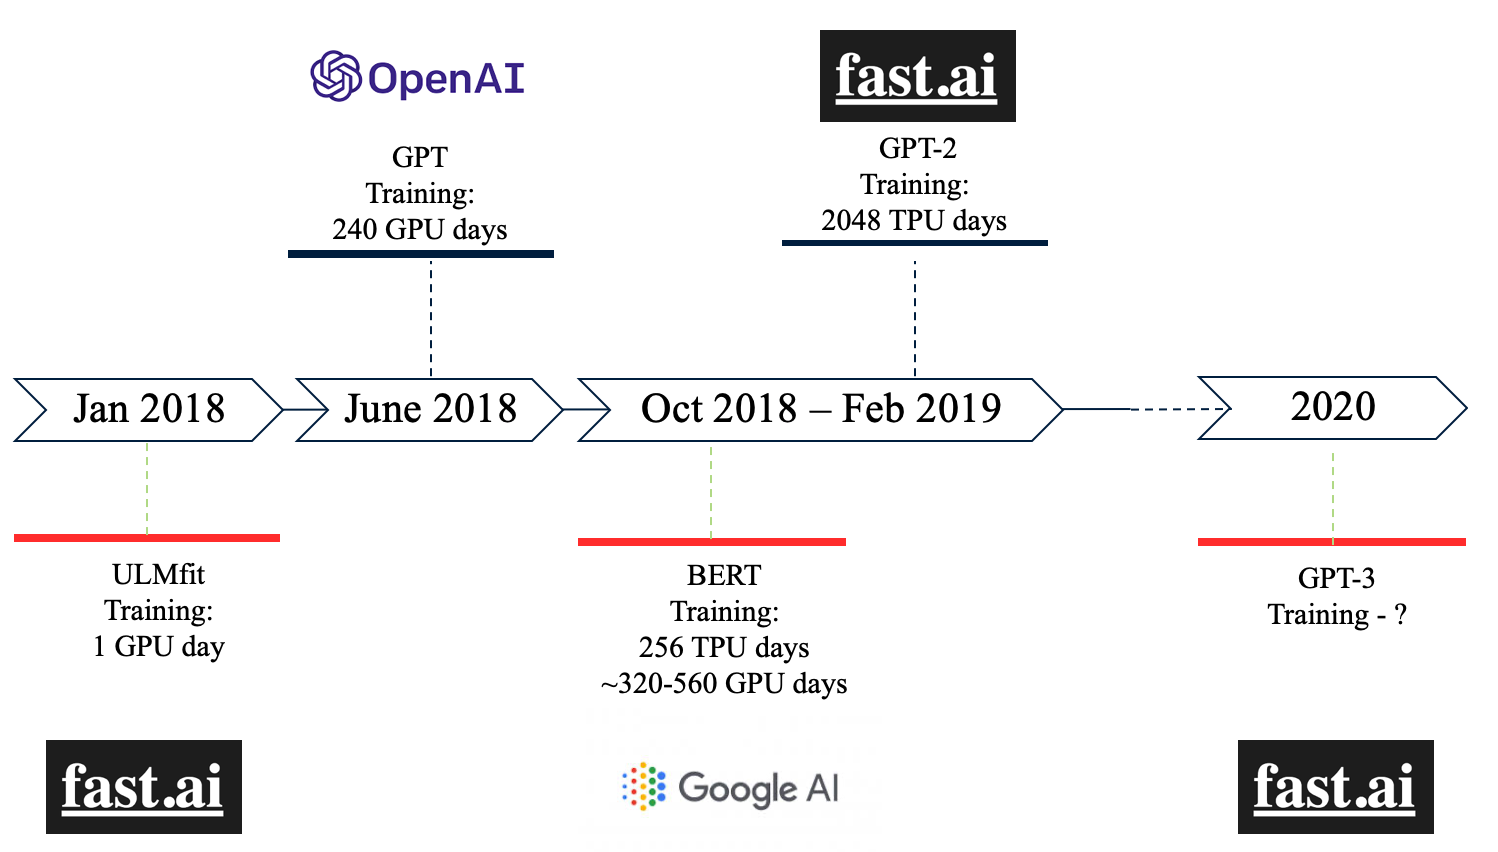

### What is BERT

BERT is a large-scale transformer-based Language Model that can be finetuned for a variety of tasks.

For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805). 

[HuggingFace documentation](https://huggingface.co/transformers/model_doc/bert.html)

[Bert documentation](https://characters.fandom.com/wiki/Bert_(Sesame_Street) ;)


Used cousera materials

Reference: https://www.coursera.org/learn/sentiment-analysis-bert/home/welcome

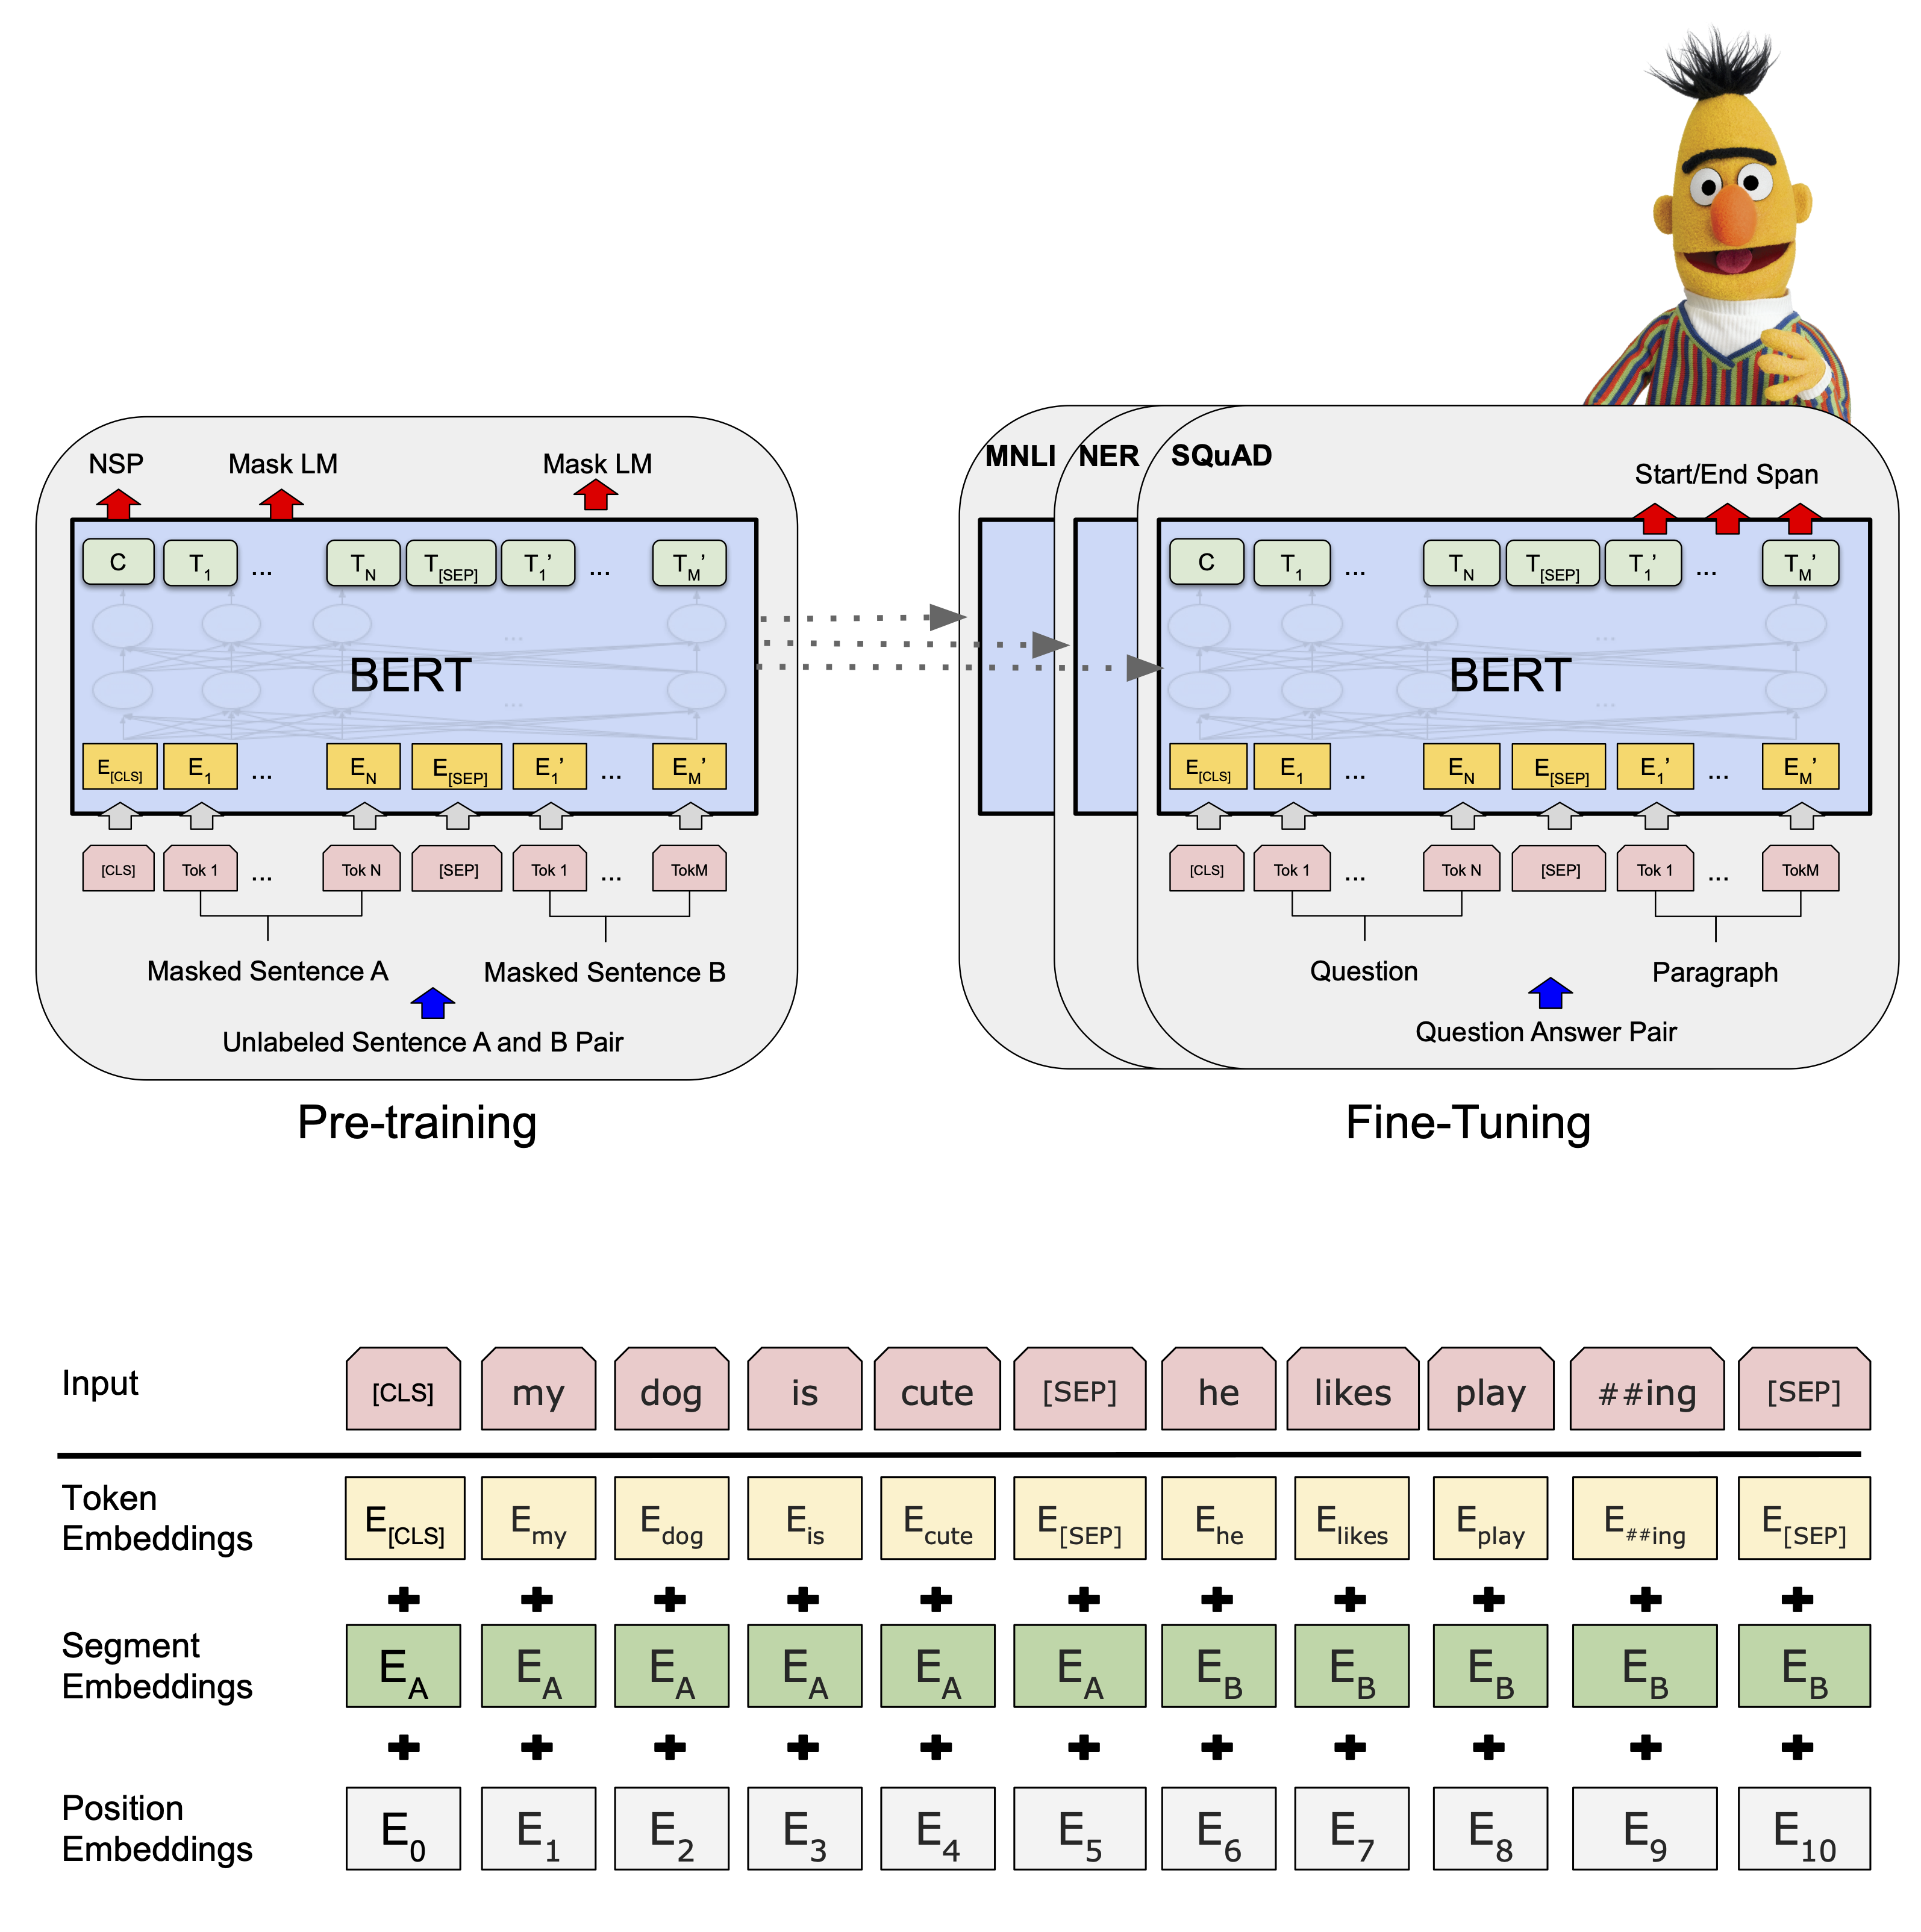

## Preprocessing

We will use Facebook status data and sentiment data:

[Sentiment](https://drive.google.com/file/d/1WGWQ5COxIiczeVrObPzn82vRsKPsmVX7/view?usp=sharing)

[Facebook status](https://drive.google.com/file/d/1MjEnp8sXgzv5HZfIy60rlfK1aTUHx948/view?usp=sharing)

In [1]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

# Facebook status data

In [5]:
df = pd.read_csv('facebook_status.csv')

In [7]:
df_status = df[["status_message"]]
df_status.head()

,status_message
0,Don't forget to ask R U OK? Even to those who ...
1,"To the rest of Aus,\nThe weather isn't always ..."
2,Let your 4-wheels help you escape the 9-5
3,A long-term relationship that gets better with...
4,Special moments don't always happen on special...


In [8]:
texts_all = df_status.values
texts_all[0:10]

array([["Don't forget to ask R U OK? Even to those who may seem a little tougher than you on the outside. #RUOK"],
       ["To the rest of Aus,\nThe weather isn't always cold and miserable here! \nSincerely, Victoria ☀️"],
       ['Let your 4-wheels help you escape the 9-5'],
       ['A long-term relationship that gets better with age.'],
       ["Special moments don't always happen on special occasions."],
       ['Spring has sprung ☀️'],
       ["Winter wasn't that bad"],
       ['Apple Carplay - Making your weekend debriefs with Nathan (whoever that is) a whole lot easier.'],
       ['In celebration of National Dog Day, may we present Moosh the Malamute - the largest dog to ever fit into our compact SUV 🐶'],
       ['If you could take any Holden on your next road trip, what would it be? 🚗🚙 \nComment below for your chance to win a hot lap in a Red Bull Holden Racing Team supercar at the Sandown 500.\nT&Cs apply: http://s.holden.com/9nge']],
      dtype=object)

# Training Data (-> testing with smaller dataset; replace with IMDB dataset in future)

In [13]:
df = pd.read_csv('Sentiment.csv')

In [15]:
df = df[['text','sentiment']]

In [16]:
df['text']

0        RT @NancyLeeGrahn: How did everyone feel about...
1        RT @ScottWalker: Didn't catch the full #GOPdeb...
2        RT @TJMShow: No mention of Tamir Rice and the ...
3        RT @RobGeorge: That Carly Fiorina is trending ...
4        RT @DanScavino: #GOPDebate w/ @realDonaldTrump...
                               ...                        
13866    RT @cappy_yarbrough: Love to see men who will ...
13867    RT @georgehenryw: Who thought Huckabee exceede...
13868    RT @Lrihendry: #TedCruz As President, I will a...
13869    RT @JRehling: #GOPDebate Donald Trump says tha...
13870    RT @Lrihendry: #TedCruz headed into the Presid...
Name: text, Length: 13871, dtype: object

In [17]:
df.sentiment.value_counts()

Negative    8493
Neutral     3142
Positive    2236
Name: sentiment, dtype: int64

In [18]:
possible_labels = df.sentiment.unique()

In [19]:
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [20]:
df['label'] = df.sentiment.replace(label_dict)

In [21]:
df.head()

,text,sentiment,label
0,RT @NancyLeeGrahn: How did everyone feel about...,Neutral,0
1,RT @ScottWalker: Didn't catch the full #GOPdeb...,Positive,1
2,RT @TJMShow: No mention of Tamir Rice and the ...,Neutral,0
3,RT @RobGeorge: That Carly Fiorina is trending ...,Positive,1
4,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,Positive,1


In [22]:
df['label'].values

array([0, 1, 0, ..., 1, 2, 1])

## Training/Validation Split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
train, val = train_test_split(df,
                              test_size=0.15,
                              random_state=17,
                              stratify=df.label.values)

## Loading Tokenizer and Encoding our Data

In [25]:
%%bash
pip install transformers

  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=f4959c3e3c4e47f60b2749bc865fe25856a15e6efd201fee81825ef298bd5e2d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [26]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [27]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [28]:
encoded_data_train = tokenizer.batch_encode_plus(
    train['text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    val['text'].values, 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    max_length=256, 
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train['label'].values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(val['label'].values)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [29]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [30]:
len(dataset_train)

11790

In [31]:
len(dataset_val)

2081

## Setting up BERT Pretrained Model

In [32]:
from transformers import BertForSequenceClassification

In [33]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## Creating Data Loaders

In [34]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [35]:
batch_size = 32 #4

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

## Setting Up Optimiser and Scheduler

In [36]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [37]:
optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)

In [38]:
epochs = 2

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

## Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [39]:
import numpy as np

In [40]:
from sklearn.metrics import f1_score

In [41]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [42]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [43]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [45]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [46]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


Epoch 1
Training loss: 0.7729069575223173



Validation loss: 0.6943328046437466
F1 Score (Weighted): 0.7073766801414655



Epoch 2
Training loss: 0.6343049306048933



Validation loss: 0.6858912981820829
F1 Score (Weighted): 0.7081984510387299



In [47]:
accuracy_per_class(predictions, true_vals)

Class: Neutral
Accuracy: 175/471

Class: Positive
Accuracy: 221/336

Class: Negative
Accuracy: 1107/1274



In [48]:
from google.colab import files
files.download("finetuned_BERT_epoch_2.model") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# When using saved model

In [49]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)
pass

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [50]:
#model.load_state_dict(torch.load('Models/<<INSERT MODEL NAME HERE>>.model', map_location=torch.device('cpu')))

In [54]:
model.load_state_dict(torch.load('/content/finetuned_BERT_epoch_1.model',
              map_location=torch.device('cpu'))
)

<All keys matched successfully>

In [55]:
_, predictions, true_vals = evaluate(dataloader_validation)

In [56]:
accuracy_per_class(predictions, true_vals)

Class: Neutral
Accuracy: 190/471

Class: Positive
Accuracy: 211/336

Class: Negative
Accuracy: 1094/1274

